In [1]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set_context('notebook')

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
# load pre-processed data
doc2vecData = pickle.load( open( "cleaned_train.pkl", "rb" ) )
train_df = doc2vecData[0]
y_train = train_df.Class
solution_df_truncated = doc2vecData[3]
desired_class = doc2vecData[4]

# run this notebook on doc2vec training/testing set
X_train_array = doc2vecData[6]
X_test_array = doc2vecData[7]

# run this notebook on bag of words training/testing set
#X_train_array, X_test_array = pickle.load( open( "cleaned_test_bag_words.pkl", "rb" ) )

# run this notebook on TF-IDF training/testing set
#X_train_arrays_non_truncated, X_train_array, X_test_array = pickle.load( open( "cleaned_test_tfidf.pkl", "rb" ) )

In [3]:
# 1. Transform categorical labels to numerical labels between 0 and len(labels) using labelEncoder
# 2. one hot encode our label
y_train = train_df.Class
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_hot = np_utils.to_categorical(label_encoder.transform(y_train))

# target labels
y_true = [int(x) for x in desired_class.ravel()]
y_true_oh = solution_df_truncated.values

In [4]:
# put everything together into a function
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true,y_pred,title='ROC title'):
    # calculate ROC in a one-vs-all manner
    # y_true needs to be binary (one-hot encoded)
    # y_pred needs to be probabilities
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    num_classes = y_true.shape[1]

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='Class %i (area = %0.2f)' %(i+1,roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

In [5]:
def plot_confusion_matrix(y_true,y_pred_proba):
    # decode
    y_pred_k1 = y_pred_proba.argmax(axis=-1)
    y_pred = label_encoder.inverse_transform(y_pred_k1)
    
    # build confusion matrix
    confusion = pd.crosstab(pd.Series(y_true),pd.Series(y_pred),margins = False)
    sns.heatmap(confusion,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Desired')
    plt.show()
    
    print(classification_report(y_true,y_pred))
    print('MCC:', matthews_corrcoef(y_true,y_pred))

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


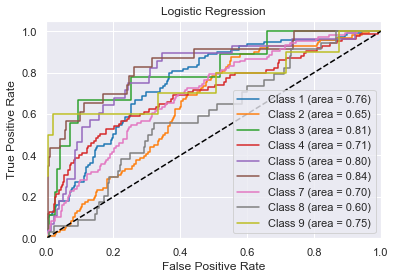

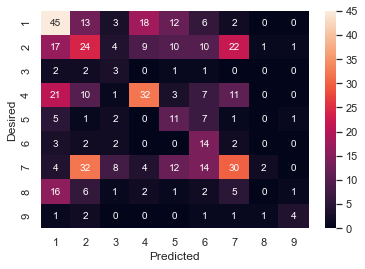

              precision    recall  f1-score   support

           1       0.39      0.45      0.42        99
           2       0.26      0.24      0.25        98
           3       0.12      0.33      0.18         9
           4       0.49      0.38      0.43        85
           5       0.22      0.39      0.28        28
           6       0.23      0.61      0.33        23
           7       0.41      0.28      0.33       106
           8       0.00      0.00      0.00        34
           9       0.57      0.40      0.47        10

    accuracy                           0.33       492
   macro avg       0.30      0.34      0.30       492
weighted avg       0.34      0.33      0.33       492

MCC: 0.21347160703565707


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


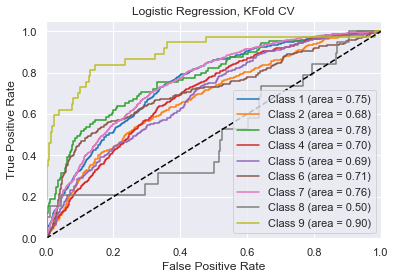

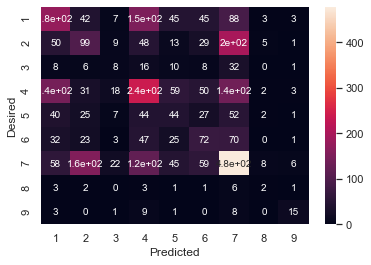

              precision    recall  f1-score   support

           1       0.38      0.34      0.36       566
           2       0.33      0.28      0.31       452
           3       0.23      0.19      0.21        89
           4       0.36      0.36      0.36       686
           5       0.22      0.22      0.22       242
           6       0.33      0.35      0.34       273
           7       0.50      0.57      0.53       952
           8       0.09      0.11      0.10        19
           9       0.44      0.38      0.41        37

    accuracy                           0.39      3316
   macro avg       0.32      0.31      0.31      3316
weighted avg       0.38      0.39      0.39      3316

MCC: 0.24658073228629926


In [6]:
# logistic regression
model = LogisticRegression()
model.fit(X_train_array,y_train)
y_pred = model.predict_proba(X_test_array)
auc_logit = plot_roc(y_true_oh, y_pred,'Logistic Regression')
plot_confusion_matrix(y_true,y_pred)

y_pred = cross_val_predict(model, X_train_array, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
auc_logit = plot_roc(y_train_hot, y_pred,'Logistic Regression, KFold CV')
plot_confusion_matrix(y_train,y_pred)

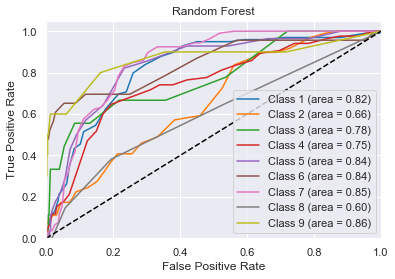

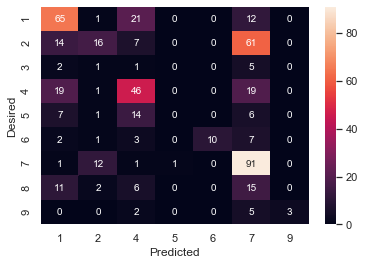

              precision    recall  f1-score   support

           1       0.54      0.66      0.59        99
           2       0.46      0.16      0.24        98
           3       0.00      0.00      0.00         9
           4       0.46      0.54      0.49        85
           5       0.00      0.00      0.00        28
           6       1.00      0.43      0.61        23
           7       0.41      0.86      0.56       106
           8       0.00      0.00      0.00        34
           9       1.00      0.30      0.46        10

    accuracy                           0.47       492
   macro avg       0.43      0.33      0.33       492
weighted avg       0.43      0.47      0.41       492

MCC: 0.35939166440305687


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# model built on training data and evaluated on test data
# RFC
model = RandomForestClassifier()
model.fit(X_train_array,y_train)
y_pred = model.predict_proba(X_test_array)
auc_logit = plot_roc(y_true_oh, y_pred,'Random Forest')
plot_confusion_matrix(y_true,y_pred)

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


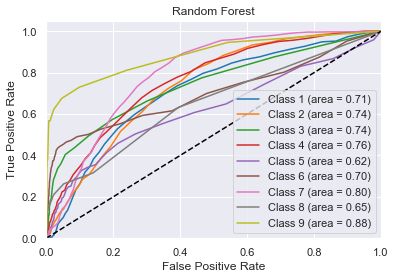

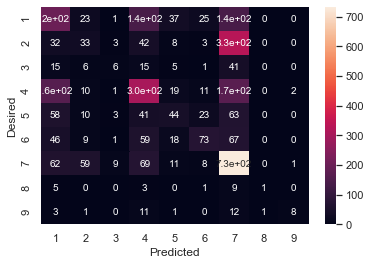

              precision    recall  f1-score   support

           1       0.35      0.36      0.36       566
           2       0.21      0.07      0.11       452
           3       0.29      0.08      0.12        89
           4       0.44      0.44      0.44       686
           5       0.24      0.14      0.18       242
           6       0.66      0.35      0.46       273
           7       0.49      0.80      0.60       952
           8       0.50      0.05      0.10        19
           9       0.55      0.16      0.25        37

    accuracy                           0.44      3316
   macro avg       0.42      0.27      0.29      3316
weighted avg       0.41      0.44      0.40      3316

MCC: 0.2852418563358572


In [8]:
# model built on training data w/ k-fold cross validation, evaluated on training data
y_pred = cross_val_predict(model, X_train_array, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
auc_logit = plot_roc(y_train_hot, y_pred,'Random Forest')
plot_confusion_matrix(y_train,y_pred)

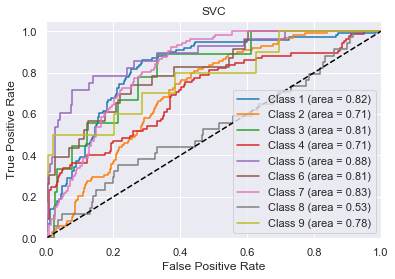

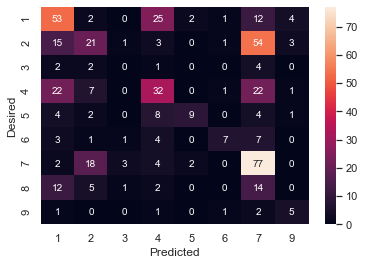

              precision    recall  f1-score   support

           1       0.46      0.54      0.50        99
           2       0.36      0.21      0.27        98
           3       0.00      0.00      0.00         9
           4       0.40      0.38      0.39        85
           5       0.69      0.32      0.44        28
           6       0.64      0.30      0.41        23
           7       0.39      0.73      0.51       106
           8       0.00      0.00      0.00        34
           9       0.36      0.50      0.42        10

    accuracy                           0.41       492
   macro avg       0.37      0.33      0.33       492
weighted avg       0.40      0.41      0.38       492

MCC: 0.2885246721787142


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# SVC
model = SVC(kernel='sigmoid',gamma='auto',probability=True)
model.fit(X_train_array,y_train)
y_pred = model.predict_proba(X_test_array)
auc_logit = plot_roc(y_true_oh, y_pred,'SVC')
plot_confusion_matrix(y_true,y_pred)

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


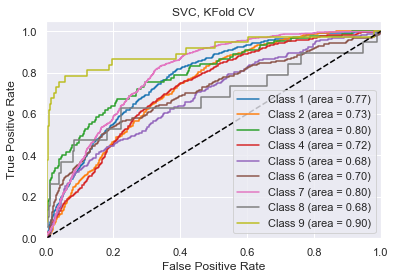

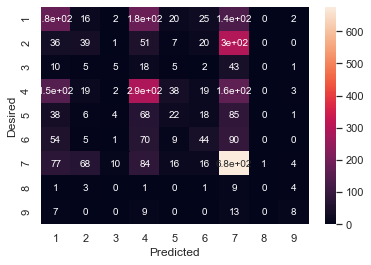

              precision    recall  f1-score   support

           1       0.41      0.40      0.40       566
           2       0.27      0.10      0.14       452
           3       0.52      0.15      0.23        89
           4       0.39      0.44      0.41       686
           5       0.16      0.08      0.11       242
           6       0.36      0.19      0.25       273
           7       0.49      0.78      0.60       952
           8       0.00      0.00      0.00        19
           9       0.39      0.24      0.30        37

    accuracy                           0.42      3316
   macro avg       0.33      0.26      0.27      3316
weighted avg       0.39      0.42      0.38      3316

MCC: 0.2669421187426905


In [10]:
y_pred = cross_val_predict(model, X_train_array, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
auc_logit = plot_roc(y_train_hot, y_pred,'SVC, KFold CV')
plot_confusion_matrix(y_train,y_pred)